
# ANALISI E PULIZIA DATASET

In [1]:
#IMPORTO LIBRERIE
import pandas as pd
import numpy as np

In [25]:
#monto il drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('corporate-transactions-with-users-without-vat.csv', sep=";" , engine="python", encoding="ISO-8859-1" )
df.shape

(317287, 25)

In [3]:
#carico il csv in un dataframe
df = pd.read_csv('/content/drive/MyDrive/corporate-transactions-with-users-without-vat.csv', sep=";" , engine="python", encoding="ISO-8859-1" )
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/corporate-transactions-with-users-without-vat.csv'

In [ ]:
df.info()

si noti che CAP è un object, questo perché vi sono nan e 'MONTE'

In [28]:
#codice brutto ma le regex non funzionano
t1=df.CAP.unique()
temp=df[pd.to_numeric(df['CAP'], errors='coerce').notnull()] #solo CAP numerici
t2=temp.CAP.unique()
print([a for a in t1 if a not in t2])

[nan, 'MONTE']


In [ ]:
df.describe()

notiamo la scarsa percentuale di userAgent_isBot, 

In [ ]:
#premere sulla bacchetta per la visualizzazione fino alla colonna 20
df[df['userAgent_isBot']==1]

In [ ]:
#continuazione della tabella
df[df['userAgent_isBot']==1].iloc[ : , -5:]

userAgent_isBot, avendo campi NaN verranno filtrati tutti.

In [ ]:
df.companyType.unique()

notare il valore '****'

In [3]:
#PULIZIA DATASET E RIMOZIONE COLONNE DEPRECATE

#df['datetime'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %I:%M:%S.%f', infer_datetime_format=True)

def data_cleaning(df):
  df = df.drop(columns=['loginMode', 'isFraud', 'bankCode']) #inutili
  df = df.drop(columns=['BIC_locationCode','BIC_branchCode','BIC_countryCode']) #incompleti
  df = df.drop(columns=['userAgent_isMobile','userAgent_isTablet','userAgent_isTouch']) #sono 99% pc
  df = df.drop(df[df.companyType=='****'].index)
  df = df.dropna()

  df = df[pd.to_numeric(df['CAP'], errors='coerce').notnull()] #solo cap numerici, filtra 'MONTE'
  df.CAP=df.CAP.astype(int)

  df.SAE = df.SAE.astype(int) #era float

  df.RAE = df.RAE.astype(int) #era float

  df['IBAN_bankCode'] = df['IBAN_bankCode'].astype('str')
  
  return df

df=data_cleaning(df)
df.head()

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_isBot,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType
0,93000801,2021-09-15 16:13:35.147,Italy,150.00,c7543b6f04850eae288aa52783b33363,1,0,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
1,93000801,2021-08-24 10:34:24.487,Greece,3200.00,c7543b6f04850eae288aa52783b33363,1,0,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
2,93000801,2021-09-14 16:21:43.33,Italy,8350.00,c7543b6f04850eae288aa52783b33363,1,0,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
3,93001001,2021-06-30 09:07:16.733,Italy,500.00,3f241dfcc38064261fec0f303c2784e5,1,0,Chrome,Windows,IT,2008,CEFGV,31039,430,505,SRL
4,93001001,2021-07-12 16:36:02.857,Italy,1895.68,a5d1eaffa8e325d370665f43624339a1,1,0,Chrome,Windows,IT,3069,CEFGV,31039,430,505,SRL


In [ ]:
df.describe()

In [4]:
#non ci sono più bonifici con isbot=1 eliminiamo la colonna
df=df.drop(columns='userAgent_isBot')
df.head()

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType
0,93000801,2021-09-15 16:13:35.147,Italy,150.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
1,93000801,2021-08-24 10:34:24.487,Greece,3200.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
2,93000801,2021-09-14 16:21:43.33,Italy,8350.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
3,93001001,2021-06-30 09:07:16.733,Italy,500.00,3f241dfcc38064261fec0f303c2784e5,1,Chrome,Windows,IT,2008,CEFGV,31039,430,505,SRL
4,93001001,2021-07-12 16:36:02.857,Italy,1895.68,a5d1eaffa8e325d370665f43624339a1,1,Chrome,Windows,IT,3069,CEFGV,31039,430,505,SRL


In [52]:
df.shape

(90960, 15)

In [9]:
df.to_csv('cleaned_data.csv')

# PREPROCESSING

*   divisione per company type in questo caso prenderemo come esempio companyType==*SRL*

*   labelencoding

In [5]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict #per creare un dizionario di label

encoder_dict = defaultdict(LabelEncoder)
columns_to_label = ['country','userAgent_browserFamily','userAgent_osFamily','IBAN_countryCode','IBAN_bankCode','CAP','SIA','SAE','RAE','companyType']


#fit+transform e aggiornamento del dizionario, restituisce il df labellato
def fit_transform_dict (df,enc_dict,columns):
  labeled=df.copy()
  for clmn in columns:
    enc_dict[clmn].fit(labeled[clmn])
    labeled[clmn]=enc_dict[clmn].transform(labeled[clmn])
  return labeled

labeled_df=fit_transform_dict(df,encoder_dict,columns_to_label)

labeled_df.head()

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType
0,93000801,2021-09-15 16:13:35.147,6,150.00,c7543b6f04850eae288aa52783b33363,1,4,5,17,699,2013,144,19,113,5
1,93000801,2021-08-24 10:34:24.487,5,3200.00,c7543b6f04850eae288aa52783b33363,1,4,5,17,699,2013,144,19,113,5
2,93000801,2021-09-14 16:21:43.33,6,8350.00,c7543b6f04850eae288aa52783b33363,1,4,5,17,699,2013,144,19,113,5
3,93001001,2021-06-30 09:07:16.733,6,500.00,3f241dfcc38064261fec0f303c2784e5,1,0,5,17,123,1781,90,8,99,10
4,93001001,2021-07-12 16:36:02.857,6,1895.68,a5d1eaffa8e325d370665f43624339a1,1,0,5,17,285,1781,90,8,99,10


In [8]:
import pickle
pickle.dump(encoder_dict, open('enc_dict.pkl','wb'))

# ANOMALY DETECTION
## ISOLATION FOREST

In [6]:
from sklearn.ensemble import IsolationForest
X=labeled_df.copy()
X=X.drop(columns=['businessName','customerId','timestamp'])
model=IsolationForest(random_state=0,contamination=0.001)
model.fit(X)
print(model.get_params())

C:\Users\Robivad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


{'bootstrap': False, 'contamination': 0.001, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [43]:
X.shape

(90960, 12)

In [53]:
model.predict(X)

array([-1, -1, -1, ...,  1,  1, -1])

In [65]:
anomaly_list=model.predict(X)
outlier_index=np.where(anomaly_list==-1)
#outlier_index.size
outlier_index[0].size

91

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

anomaly_list=model.predict(X)
outlier_index=np.where(anomaly_list==-1)
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
Y = scaler.fit_transform(X)
Y_reduce = pca.fit_transform(Y)
fig = plt.figure()
ay = fig.add_subplot(111, projection='3d')
ay.set_zlabel("y_composite_3")
# Plot the compressed data points
ay.scatter(Y_reduce[:, 0], Y_reduce[:, 1], zs=Y_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot y's for the ground truth outliers
ay.scatter(Y_reduce[outlier_index,0],Y_reduce[outlier_index,1], Y_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ay.legend()
plt.show()

In [ ]:
ay.scatter(Y_reduce[outlier_index,0],Y_reduce[outlier_index,1], Y_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers", alpha=0.1)
ay.legend()
plt.show()

In [ ]:
X.head()

In [7]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

In [19]:
def inverse_and_scores(if_df,labeled_df,enc_dict,columns,if_model):
  df_copy=labeled_df.copy()
  scores=model.decision_function(if_df)
  anomaly_score=model.predict(if_df)
  
  for clmn in columns:
   df_copy[clmn]=enc_dict[clmn].inverse_transform(df_copy[clmn])
  
  df_copy['scores'] = scores
  df_copy['anomaly_score'] = anomaly_score

  return df_copy

df_scores=inverse_and_scores(X,labeled_df,encoder_dict,columns_to_label,model)

df_scores.head()

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType,scores,anomaly_score
0,93000801,2021-09-15 16:13:35.147,Italy,150.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS,0.153537,1
1,93000801,2021-08-24 10:34:24.487,Greece,3200.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS,0.127344,1
2,93000801,2021-09-14 16:21:43.33,Italy,8350.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS,0.136098,1
3,93001001,2021-06-30 09:07:16.733,Italy,500.00,3f241dfcc38064261fec0f303c2784e5,1,Chrome,Windows,IT,2008,CEFGV,31039,430,505,SRL,0.279952,1
4,93001001,2021-07-12 16:36:02.857,Italy,1895.68,a5d1eaffa8e325d370665f43624339a1,1,Chrome,Windows,IT,3069,CEFGV,31039,430,505,SRL,0.285561,1


AttributeError: 'tuple' object has no attribute 'size'

In [20]:
model.predict(X)

array([-1, -1, -1, ...,  1,  1, -1])

In [20]:
df_scores[df_scores['anomaly_score']==-1].sort_values('scores')

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType,scores,anomaly_score
157882,41999520,2021-09-16 11:41:45.407,Italy,270000.00,d1126a5e3988d76235cde4c7eed8ebbd,0,Other,Linux,IT,3493,347D3,39038,430,830,GMBH,-0.080374,-1
153087,45915153,2021-08-24 11:47:38.077,Italy,299.00,73322bb678a4c1b6a94fe29411a5fafe,0,Other,Linux,IT,8904,082X3,30024,614,342,DI,-0.054135,-1
153077,45915153,2021-09-02 15:44:16.347,Italy,687.00,73322bb678a4c1b6a94fe29411a5fafe,0,Other,Linux,IT,8904,082X3,30024,614,342,DI,-0.052696,-1
153078,45915153,2021-04-29 14:17:14.26,Italy,1000.00,f2a85ebb8645443730a3fba554a69914,0,Other,Linux,IT,8904,082X3,30024,614,342,DI,-0.051738,-1
153074,45915153,2021-07-30 15:25:38.557,Italy,1000.00,f2a85ebb8645443730a3fba554a69914,0,Other,Linux,IT,8904,082X3,30024,614,342,DI,-0.051738,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133280,37138459,2021-04-28 17:31:45.617,Italy,1200.00,e2390d68c5d65e82e64c907234ea9497,0,Other,Linux,IT,5856,AJ822,39100,482,419,SNC,-0.000376,-1
133261,37138459,2021-05-31 12:26:50.96,Italy,1000.00,8fa0dc37670dc010628473c668cc74c0,0,Other,Linux,IT,5856,AJ822,39100,482,419,SNC,-0.000376,-1
133271,37138459,2021-05-31 12:27:54.693,Italy,1200.00,e2390d68c5d65e82e64c907234ea9497,0,Other,Linux,IT,5856,AJ822,39100,482,419,SNC,-0.000376,-1
185492,58147956,2021-09-08 09:05:32.347,Italy,554.50,ce9ac220c8cff10ee86a7bad7708142f,1,Safari,Mac OS X,IT,8904,CRUT0,31010,615,11,SS,-0.000326,-1


# PREDICT UNSEEN POINTS

In [ ]:
newpoints_df = pd.read_csv('test.csv', sep=";" , engine="python", encoding="ISO-8859-1" )
newpoints_df.head()

In [ ]:
#punti inventati per testare 
newpoints_df = pd.read_csv('/content/drive/MyDrive/test.csv', sep=";" , engine="python", encoding="ISO-8859-1" )
newpoints_df.head()

In [ ]:
newpoints_df=data_cleaning(newpoints_df)
newpoints_df.head()

In [ ]:
#label dei nuovi punti/o
#labeled_newpoints_df=fit_transform_dict(newpoints_df,encoder_dict,columns_to_label)
labeled_newpoints_df=newpoints_df.copy()
for clmn in columns_to_label:
    labeled_newpoints_df[clmn]=encoder_dict[clmn].transform(labeled_newpoints_df[clmn])

labeled_newpoints_df.head()

In [ ]:
X_test=labeled_newpoints_df.copy().drop(columns=['businessName','customerId','timestamp','companyType','userAgent_isBot'])
labeled_newpoints_scores=inverse_and_scores(X_test,labeled_newpoints_df,encoder_dict,columns_to_label,model)

#i nuovi punti col punteggio 
labeled_newpoints_scores.head()

# DECISION TREE

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')


In [7]:
test = df.copy()
test.head()

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType
0,93000801,2021-09-15 16:13:35.147,Italy,150.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
1,93000801,2021-08-24 10:34:24.487,Greece,3200.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
2,93000801,2021-09-14 16:21:43.33,Italy,8350.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
3,93001001,2021-06-30 09:07:16.733,Italy,500.00,3f241dfcc38064261fec0f303c2784e5,1,Chrome,Windows,IT,2008,CEFGV,31039,430,505,SRL
4,93001001,2021-07-12 16:36:02.857,Italy,1895.68,a5d1eaffa8e325d370665f43624339a1,1,Chrome,Windows,IT,3069,CEFGV,31039,430,505,SRL


In [8]:
test['userAgent_browserFamily'] = test['userAgent_browserFamily'].replace(['IE'],'Internet Explorer')

In [ ]:
df_scores[df_scores['anomaly_score']==-1].sort_values('scores')

In [38]:
test[test['userAgent_browserFamily']=='Internet Explorer']

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType
6758,227009801,2021-05-12 10:35:04.34,Italy,1703.00,a1bcb14e57b3ddfe757986f7b93ddd7a,1,Internet Explorer,Windows,IT,5856,AFU44,39010,482,505,SNC
6759,227009801,2021-06-07 09:45:56.77,Italy,600.00,25848fa364b1462ce90c232612e590d7,1,Internet Explorer,Windows,IT,6045,AFU44,39010,482,505,SNC
6760,227009801,2021-06-07 09:45:55.72,Italy,249.90,a21b8ff8c5e55d878226955aac85dbff,1,Internet Explorer,Windows,IT,8226,AFU44,39010,482,505,SNC
6761,227009801,2021-06-11 08:38:47.017,Italy,1672.00,a1bcb14e57b3ddfe757986f7b93ddd7a,1,Internet Explorer,Windows,IT,5856,AFU44,39010,482,505,SNC
6766,227009801,2021-07-05 11:08:25.217,Italy,600.00,dda6fe5fefbe66eaff57cd81e6f2fd86,1,Internet Explorer,Windows,IT,8226,AFU44,39010,482,505,SNC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313439,9973359401,2021-05-06 08:13:29.257,Italy,3000.00,925ed928e5d8a047ab5131460893ed17,1,Internet Explorer,Windows,IT,3069,A1D7E,36027,430,481,SRL
313442,9973359401,2021-05-11 08:52:10.873,Italy,2000.00,07016226d1dc7449cb85184842a6419b,1,Internet Explorer,Windows,IT,2008,A1D7E,36027,430,481,SRL
316618,99908211,2021-09-23 17:17:23.513,Italy,402.60,8535a649c2db72e112ea5c63961a054f,1,Internet Explorer,Windows,IT,7084,B5PGY,31027,430,830,SRL
316638,79901734,2021-07-22 16:54:18.627,Italy,1700.00,e5bdf716b8d2e86ffff44daab6f1ccf4,1,Internet Explorer,Windows,IT,3069,CS22P,36061,430,830,SRL


In [9]:
onehot_country=pd.get_dummies(test['country'])
onehot_browser=pd.get_dummies(test['userAgent_browserFamily'])
onehot_os=pd.get_dummies(test['userAgent_osFamily'])
onehot_comp_type=pd.get_dummies(test['companyType'])
onehot_country_code=pd.get_dummies(test['IBAN_countryCode'])

In [10]:
test = test.drop(columns=['customerId','timestamp','country','businessName','userAgent_browserFamily','userAgent_osFamily','IBAN_countryCode','IBAN_bankCode','SIA','CAP','SAE','RAE','companyType'])

In [11]:
test = test.join(onehot_country_code)
test = test.join(onehot_country)
test = test.join(onehot_os)
test = test.join(onehot_browser)
test = test.join(onehot_comp_type)

test.head()

,amount,userAgent_isPc,AT,BE,BG,CH,CY,CZ,DE,DK,...,KG,OHG,SAS,SCRL,SDF,SNC,SPA,SRL,SS,STU
0,150.00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,3200.00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,8350.00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,500.00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1895.68,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
onehot_browser

,Chrome,Chrome Mobile,Chrome Mobile iOS,Edge,Firefox,Google,IE,Mobile Safari,Mobile Safari UI/WKWebView,Opera,Other,Safari,Samsung Internet
0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317248,1,0,0,0,0,0,0,0,0,0,0,0,0
317249,1,0,0,0,0,0,0,0,0,0,0,0,0
317250,1,0,0,0,0,0,0,0,0,0,0,0,0
317283,1,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
test.head()

,amount,userAgent_isPc,AT,BE,BG,CH,CY,CZ,DE,DK,...,Switzerland,United Arab Emirates,United States of America,Android,Fedora,Linux,Mac OS X,Ubuntu,Windows,iOS
0,150.00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3200.00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8350.00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,500.00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1895.68,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
from sklearn.datasets import load_iris
from sklearn import tree
#X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(test, model.predict(X))

[Text(0.5704365079365079, 0.9705882352941176, 'X[66] <= 0.5\ngini = 0.002\nsamples = 90960\nvalue = [91, 90869]'),
 Text(0.33382936507936506, 0.9117647058823529, 'X[0] <= 973000.0\ngini = 0.0\nsamples = 90770\nvalue = [17, 90753]'),
 Text(0.2708333333333333, 0.8529411764705882, 'X[0] <= 155360.852\ngini = 0.0\nsamples = 90764\nvalue = [16, 90748]'),
 Text(0.19246031746031747, 0.7941176470588235, 'X[67] <= 0.5\ngini = 0.0\nsamples = 90552\nvalue = [11, 90541]'),
 Text(0.1765873015873016, 0.7352941176470589, 'gini = 0.0\nsamples = 88220\nvalue = [0, 88220]'),
 Text(0.20833333333333334, 0.7352941176470589, 'X[2] <= 0.5\ngini = 0.009\nsamples = 2332\nvalue = [11, 2321]'),
 Text(0.1626984126984127, 0.6764705882352942, 'X[4] <= 0.5\ngini = 0.005\nsamples = 2316\nvalue = [6, 2310]'),
 Text(0.14682539682539683, 0.6176470588235294, 'X[25] <= 0.5\ngini = 0.004\nsamples = 2315\nvalue = [5, 2310]'),
 Text(0.10317460317460317, 0.5588235294117647, 'X[0] <= 99200.16\ngini = 0.003\nsamples = 2308\nval

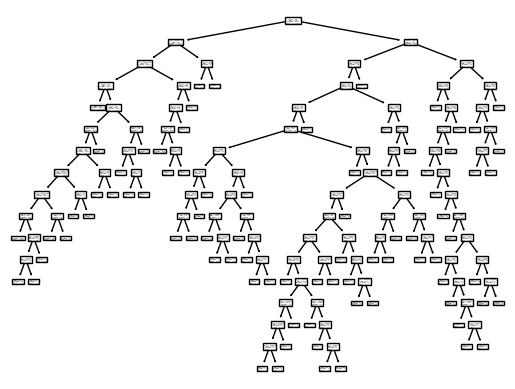

In [45]:
tree.plot_tree(clf)

In [31]:
clf.classes_

array([-1,  1])

In [32]:
class_names=['Anomalia','Normale']

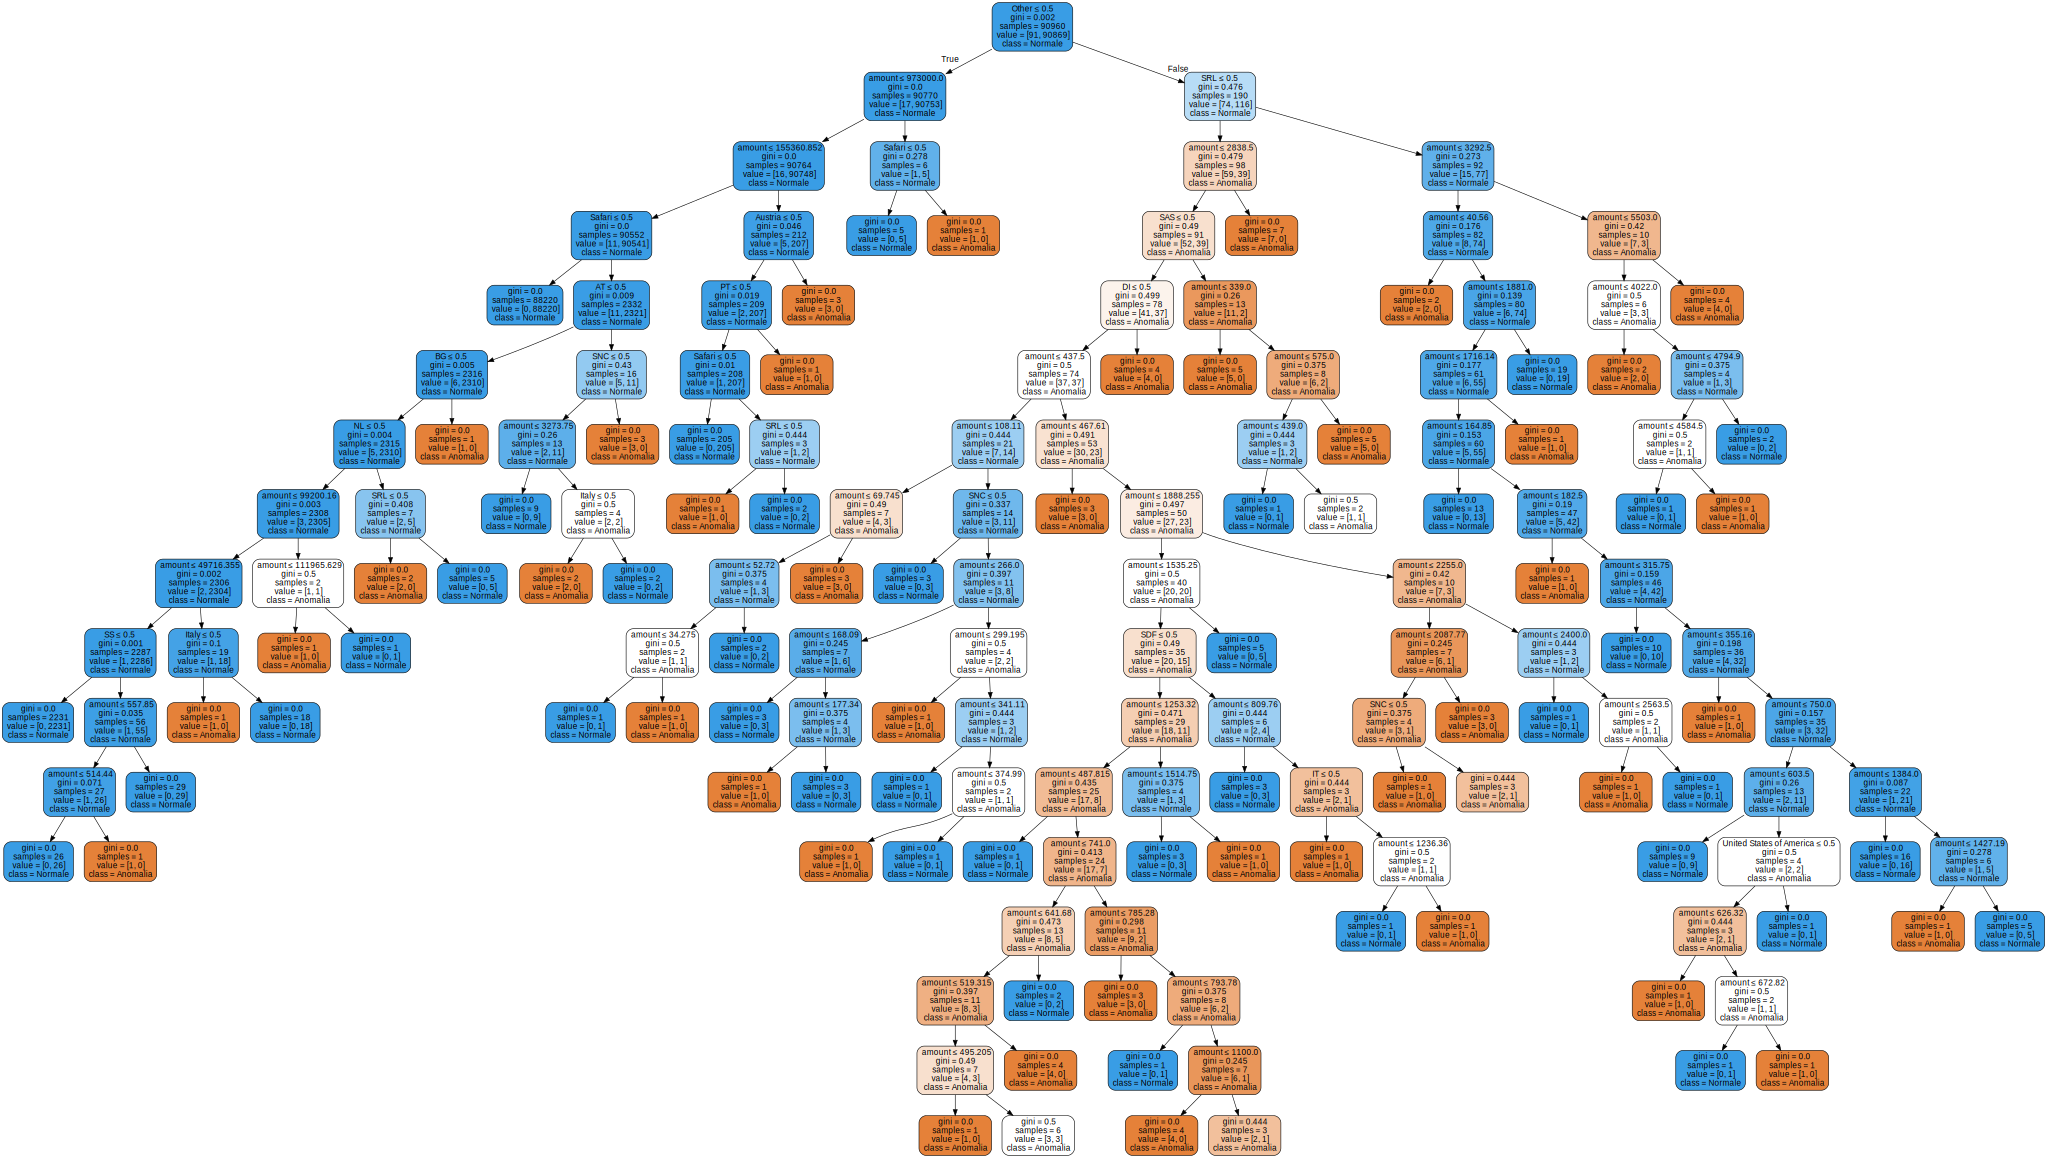

In [33]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                                filled=True, rounded=True, feature_names=test.columns, class_names=class_names,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [47]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [12]:
df.head()

,customerId,timestamp,country,amount,businessName,userAgent_isPc,userAgent_browserFamily,userAgent_osFamily,IBAN_countryCode,IBAN_bankCode,SIA,CAP,SAE,RAE,companyType
0,93000801,2021-09-15 16:13:35.147,Italy,150.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
1,93000801,2021-08-24 10:34:24.487,Greece,3200.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
2,93000801,2021-09-14 16:21:43.33,Italy,8350.00,c7543b6f04850eae288aa52783b33363,1,Firefox,Windows,IT,5856,CLFUY,33077,492,630,SAS
3,93001001,2021-06-30 09:07:16.733,Italy,500.00,3f241dfcc38064261fec0f303c2784e5,1,Chrome,Windows,IT,2008,CEFGV,31039,430,505,SRL
4,93001001,2021-07-12 16:36:02.857,Italy,1895.68,a5d1eaffa8e325d370665f43624339a1,1,Chrome,Windows,IT,3069,CEFGV,31039,430,505,SRL


In [30]:
test[test['Other']==1]


,amount,userAgent_isPc,AT,BE,BG,CH,CY,CZ,DE,DK,...,KG,OHG,SAS,SCRL,SDF,SNC,SPA,SRL,SS,STU
25191,1213.96,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
40758,60.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
73644,1050.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81975,700.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81979,1750.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308460,80.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
316869,500.00,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
316981,127.49,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
316982,774.24,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
